<a href="https://www.kaggle.com/code/vaibsdev/notebook5d95578c5e?scriptVersionId=234300192" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import pickle
import warnings
import pandas as pd
!pip install torchinfo
from torchinfo import summary
import gc

warnings.filterwarnings('ignore')

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")


def move_to_device(obj, device):
    if isinstance(obj, torch.nn.Module):
        return obj.to(device)
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    return obj


sample_tensor = torch.tensor([1.0]).to(device)
print(f"Tensor on {sample_tensor.device}")


Using device: cuda
CUDA Available: True
CUDA Device Count: 2
CUDA Device Name: Tesla T4
Tensor on cuda:0


In [5]:

class EarlyStopping:
    """Early stopping handler to prevent overfitting"""
    def __init__(self, patience=5, min_delta=0.001, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model
            torch.save(model.state_dict(), self.save_path)
            print(f"[INFO] Model checkpoint saved to {self.save_path}")
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("[INFO] Early stopping triggered.")
                return True
        return False

In [6]:

csv_path = '/kaggle/input/mst-e-data-1/mst-e_data/mst-e_image_details.csv'
image_data = pd.read_csv(csv_path)


image_paths = []
labels = []


base_image_dir = "/kaggle/input/mst-e-data-1/mst-e_data"


unique_mst_classes = sorted(image_data['MST'].unique())
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_mst_classes)}
num_classes = len(unique_mst_classes)
print(f"Number of unique MST classes: {num_classes}")
print(f"Class mapping: {class_to_idx}")


for index, row in image_data.iterrows():
    # Get image details from your columns
    image_id = row['image_ID']
    subject_name = row['subject_name']

 
    mst_class = row['MST']
    class_idx = class_to_idx[mst_class]

    image_path = os.path.join(base_image_dir, subject_name, f"{image_id}")

    # Skip if this is an MP4 file
    if image_path.lower().endswith('.mp4'):
        continue

    
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(class_idx)  
    else:
        print(f"Image not found: {image_path}")

print(f"Found {len(image_paths)} images across {num_classes} MST classes")

Number of unique MST classes: 10
Class mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}
Image not found: /kaggle/input/mst-e-data-1/mst-e_data/subject_18/PXL_20220922_183142438.jpg 
Image not found: /kaggle/input/mst-e-data-1/mst-e_data/subject_2/bottom
Found 1510 images across 10 MST classes


In [7]:
class SkinToneDataset(Dataset):
    """Custom Dataset for loading skin tone images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

RESNet


In [38]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [40]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_dataset = SkinToneDataset(train_paths, train_labels, transform=transform)
val_dataset = SkinToneDataset(val_paths, val_labels, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [25]:
import torchvision.models as models

class SkinToneResNet(nn.Module):
    """ResNet-based model for skin tone classification."""
    def __init__(self, num_classes):
        super(SkinToneResNet, self).__init__()
        
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Freeze feature extraction layers for transfer learning
        for param in self.resnet.parameters():
            param.requires_grad = False  

        # Modify the fully connected layer for our task
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkinToneResNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.0005, weight_decay=1e-4)  # L2 regularization
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [27]:
num_epochs = 15  # Adjust as needed
early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path="best_model.pth")

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()  # Adjust learning rate

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / len(val_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if early_stopping(val_loss, model):
        break 
    

Epoch 1/1: 100%|██████████| 38/38 [01:28<00:00,  2.34s/it]

[Epoch 1] Train Loss: 1.8976, Accuracy: 0.3651


Validation Loss: 1.3283, Validation Accuracy: 0.7914
[INFO] Model checkpoint saved to best_model.pth


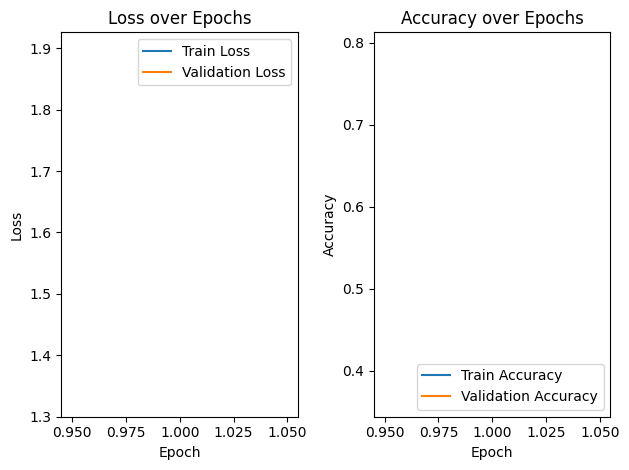

In [28]:
# Plot Losses
epochs_range = range(1, len(train_losses) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [29]:
# After training completes, to clear GPU memory:
model = model.to('cpu')  # Move model back to CPU
torch.cuda.empty_cache()  # Clear CUDA cache
gc.collect()  # Trigger garbage collection

# # If you're working in a notebook, you might want to manually delete variables
# del model, train_loader, val_loader, images, labels, outputs, loss, optimizer, scheduler
# gc.collect()  # Run garbage collection again
# torch.cuda.empty_cache()  # Empty cache once more

7111

-------------------------------------------------------------------------------

In [8]:
class SkinToneModel(nn.Module):
    """Convolutional Neural Network for skin tone classification"""
    def __init__(self, num_classes, dropout_rate=0.3):
        super(SkinToneModel, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(p=0.3)
        )
        
        # Corrected input channels from 512 to 256
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding="same"),  # in_channels=256
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)  # Corrected from 512 to 256
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)
        x = self.fc_block(x)
        return x


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = SkinToneDataset(image_paths, labels, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,persistent_workers=True,pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,persistent_workers=True,pin_memory = True)

device = torch.device("cuda" if torch.cuda.is_available() else print("ERROR"))
model = SkinToneModel(num_classes=num_classes).to(device)


print("Basic Model:")
print(summary(model, input_size=(1, 3, 224, 224)))
# print("\nLighting-Aware Model:")
# print(summary(lighting_model, input_size=(1, 3, 224, 224)))


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) #changed 


Basic Model:
Layer (type:depth-idx)                   Output Shape              Param #
SkinToneModel                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 112, 112]        256
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-8                    [1, 128, 56, 56]          --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]      

In [9]:
#FOR NORMAL MODEL
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move to GPU

        optimizer.zero_grad()  

        outputs = model(inputs)  
        loss = criterion(outputs, labels)

        loss.backward()  
        optimizer.step() 

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total
    print(epoch_loss)
    print(epoch_acc)

    return epoch_loss, epoch_acc


# Ensure model is on GPU
model.to(device)


early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path="best_skin_tone_model.pth")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

     # Save loss and accuracy for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if early_stopping(val_loss, model):
        print(f"Training stopped early at epoch {epoch+1}")
        break

print(f'Training complete! Best validation loss: {early_stopping.best_loss:.4f}')

# Load the best model for evaluation
model.load_state_dict(torch.load(early_stopping.save_path, map_location=device))
final_val_loss, final_val_acc = validate(model, val_loader, criterion, device)
print(f'Final model performance - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_acc:.2f}%')

1.8106609669742206
35.76158940397351
Epoch 1/50: Train Loss: 1.8527, Train Acc: 40.81%, Val Loss: 1.8107, Val Acc: 35.76%
[INFO] Model checkpoint saved to best_skin_tone_model.pth


KeyboardInterrupt: 

In [ ]:

class SkinToneDataset(Dataset):
    """Custom Dataset for loading skin tone images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)
class LightingAwareAttention(nn.Module):
    """Attention mechanism to focus on lighting-invariant features"""
    def __init__(self, in_channels):
        super(LightingAwareAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Global average pooling to capture lighting information
        avg_pool = torch.mean(x, dim=[2, 3], keepdim=True)
        
        # Apply attention calculation
        y = self.conv1(avg_pool)
        y = nn.ReLU()(y)
        y = self.conv2(y)
        y = self.sigmoid(y)
        
        # Apply attention weights to input features
        return x * y

class SkinToneModelWithLighting(nn.Module):
    """Convolutional Neural Network for skin tone classification with lighting awareness"""
    def __init__(self, num_classes, dropout_rate=0.3):
        super(SkinToneModelWithLighting, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Add first lighting attention after initial feature extraction
        self.lighting_attention1 = LightingAwareAttention(128)
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Add second lighting attention for higher-level features
        self.lighting_attention2 = LightingAwareAttention(512)
        
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dual branch for skin tone and lighting-aware features
        self.skin_tone_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        
        self.lighting_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
        )
        
        # Combine both branches for final classification
        self.classifier = nn.Linear(256 + 128, num_classes)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        
        # Apply first lighting attention
        x = self.lighting_attention1(x)
        
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        
        # Apply second lighting attention
        x = self.lighting_attention2(x)
        
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)
        
        # Split into two branches
        skin_features = self.skin_tone_branch(x)
        lighting_features = self.lighting_branch(x)
        
        # Concatenate features from both branches
        combined_features = torch.cat((skin_features, lighting_features), dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        
        return output

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = SkinToneDataset(image_paths, labels, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,persistent_workers=True,pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,persistent_workers=True,pin_memory = True)

lighting_model = SkinToneModelWithLighting(num_classes=num_classes).to(device)
print("\nLighting-Aware Model:")
print(summary(lighting_model, input_size=(1, 3, 224, 224)))
criterion = nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(lighting_model.parameters(), lr=0.0003)





In [ ]:
#FOR LIGHT ATTENTION
def train_one_epoch(lighting_model, dataloader, criterion, optimizer, device):
    lighting_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move to GPU

        optimizer.zero_grad()  

        outputs = lighting_model(inputs)  
        loss = criterion(outputs, labels)

        loss.backward()  
        optimizer.step() 

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

def validate(lighting_model, dataloader, criterion, device):
    lighting_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = lighting_model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total
    print(epoch_loss)
    print(epoch_acc)

    return epoch_loss, epoch_acc


# Ensure model is on GPU
lighting_model.to(device)


early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path="best_skin_tone_model_with_lightingAttention.pth")

train1_losses = []
val1_losses = []
train1_accuracies = []
val1_accuracies = []
num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(lighting_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(lighting_model, val_loader, criterion, device)

     # Save loss and accuracy for visualization
    train1_losses.append(train_loss)
    val1_losses.append(val_loss)
    train1_accuracies.append(train_acc)
    val1_accuracies.append(val_acc)


    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if early_stopping(val_loss, lighting_model):
        print(f"Training stopped early at epoch {epoch+1}")
        break

print(f'Training complete! Best validation loss: {early_stopping.best_loss:.4f}')

# Load the best model for evaluation
lighting_model.load_state_dict(torch.load(early_stopping.save_path, map_location=device))
final_val_loss, final_val_acc = validate(lighting_model, val_loader, criterion, device)
print(f'Final model performance - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_acc:.2f}%')

In [ ]:
    # Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train1_losses, label="Train Loss", marker="o")
plt.plot(val1_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train1_accuracies, label="Train Accuracy", marker="o")
plt.plot(val1_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Ensure all lists are the same length
min_epochs = min(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies),
                 len(train1_losses), len(val1_losses), len(train1_accuracies), len(val1_accuracies))

# Trim lists to the shortest epoch count
train_losses = train_losses[:min_epochs]
val_losses = val_losses[:min_epochs]
train_accuracies = train_accuracies[:min_epochs]
val_accuracies = val_accuracies[:min_epochs]
train1_losses = train1_losses[:min_epochs]
val1_losses = val1_losses[:min_epochs]
train1_accuracies = train1_accuracies[:min_epochs]
val1_accuracies = val1_accuracies[:min_epochs]

# Creating a dataframe for comparison
data = {
    "Epoch": list(range(1, min_epochs + 1)),
    "Train Loss (Normal)": train_losses,
    "Val Loss (Normal)": val_losses,
    "Train Acc (Normal)": train_accuracies,
    "Val Acc (Normal)": val_accuracies,
    "Train Loss (Light Attention)": train1_losses,
    "Val Loss (Light Attention)": val1_losses,
    "Train Acc (Light Attention)": train1_accuracies,
    "Val Acc (Light Attention)": val1_accuracies,
}

results_df = pd.DataFrame(data)
display(results_df)  # Display the table in Jupyter Notebook

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results_df["Epoch"], results_df["Train Loss (Normal)"], label='Train Loss (Normal)')
plt.plot(results_df["Epoch"], results_df["Val Loss (Normal)"], label='Val Loss (Normal)')
plt.plot(results_df["Epoch"], results_df["Train Loss (Light Attention)"], label='Train Loss (Light Attention)')
plt.plot(results_df["Epoch"], results_df["Val Loss (Light Attention)"], label='Val Loss (Light Attention)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.grid()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(results_df["Epoch"], results_df["Train Acc (Normal)"], label='Train Acc (Normal)')
plt.plot(results_df["Epoch"], results_df["Val Acc (Normal)"], label='Val Acc (Normal)')
plt.plot(results_df["Epoch"], results_df["Train Acc (Light Attention)"], label='Train Acc (Light Attention)')
plt.plot(results_df["Epoch"], results_df["Val Acc (Light Attention)"], label='Val Acc (Light Attention)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison")
plt.legend()
plt.grid()

plt.show()

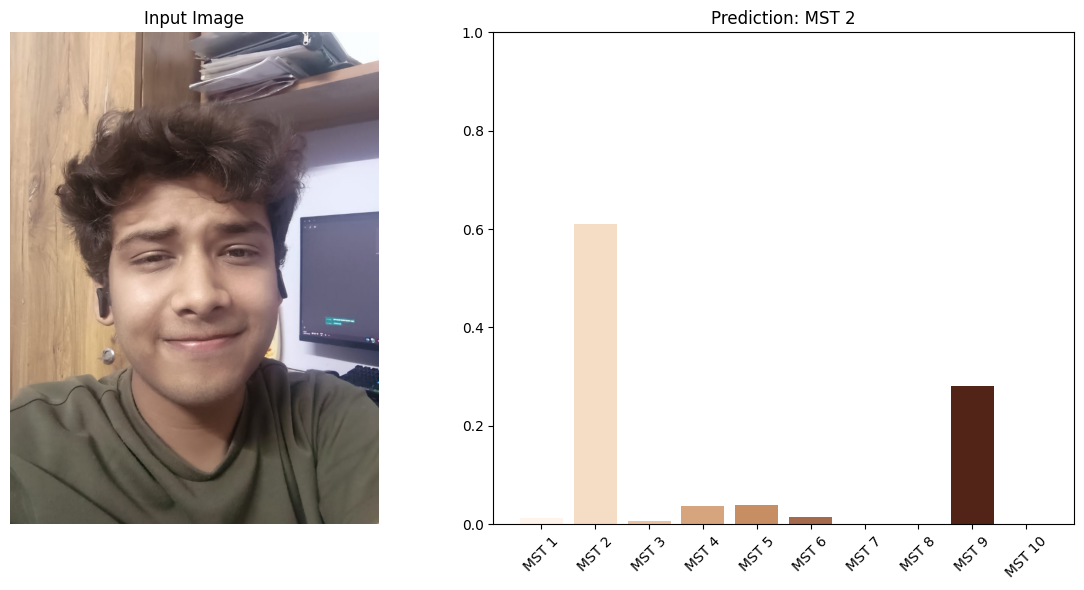


Predicted skin tone: MST 2

Probabilities for each class:
MST 1: 0.0134
MST 2: 0.6093
MST 3: 0.0055
MST 4: 0.0375
MST 5: 0.0379
MST 6: 0.0140
MST 7: 0.0003
MST 8: 0.0007
MST 9: 0.2803
MST 10: 0.0011


In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the model architecture
class SkinToneResNet(nn.Module):
    """ResNet-based model for skin tone classification using the MST scale."""
    def __init__(self, num_classes):
        super(SkinToneResNet, self).__init__()
        
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Freeze feature extraction layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Modify the fully connected layer for classification
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

# Define MST class names (1 = lightest, 10 = darkest)
class_names = [
    "MST 1", "MST 2", "MST 3", "MST 4", "MST 5",
    "MST 6", "MST 7", "MST 8", "MST 9", "MST 10"
]
num_classes = len(class_names)

# Optional: MST scale colors for bar chart visualization
mst_colors = [
    "#fef4ec", "#f4dcc5", "#eac2a1", "#d6a57d", "#c78d63",
    "#a5694c", "#8c4b32", "#703624", "#512417", "#2c140c"
]

# Function to load the trained model
def load_model(model_path, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SkinToneResNet(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model, device

# Function to predict skin tone
def predict_skin_tone(model, image_path, class_names, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    original_image = np.array(image)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # Show input image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Input Image")
    plt.axis('off')
    
    # Show probability bar chart with MST colors
    probs = probabilities.cpu().numpy()
    plt.subplot(1, 2, 2)
    plt.bar(class_names, probs, color=mst_colors)
    plt.title(f"Prediction: {class_names[predicted_class]}")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    # Print predictions
    print(f"\nPredicted skin tone: {class_names[predicted_class]}")
    print("\nProbabilities for each class:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probs[i]:.4f}")
    
    return class_names[predicted_class], probs

# Main execution
if __name__ == "__main__":
    # Update with your actual model and image path
    model_path = "/kaggle/input/best_model_res/pytorch/default/1/best_model.pth"
    image_path = "/kaggle/input/inference-img/WhatsApp Image 2025-04-16 at 9.48.38 PM.jpeg"
    
    # Load the model
    model, device = load_model(model_path, num_classes)
    
    # Predict skin tone
    predicted_class, probabilities = predict_skin_tone(model, image_path, class_names, device)


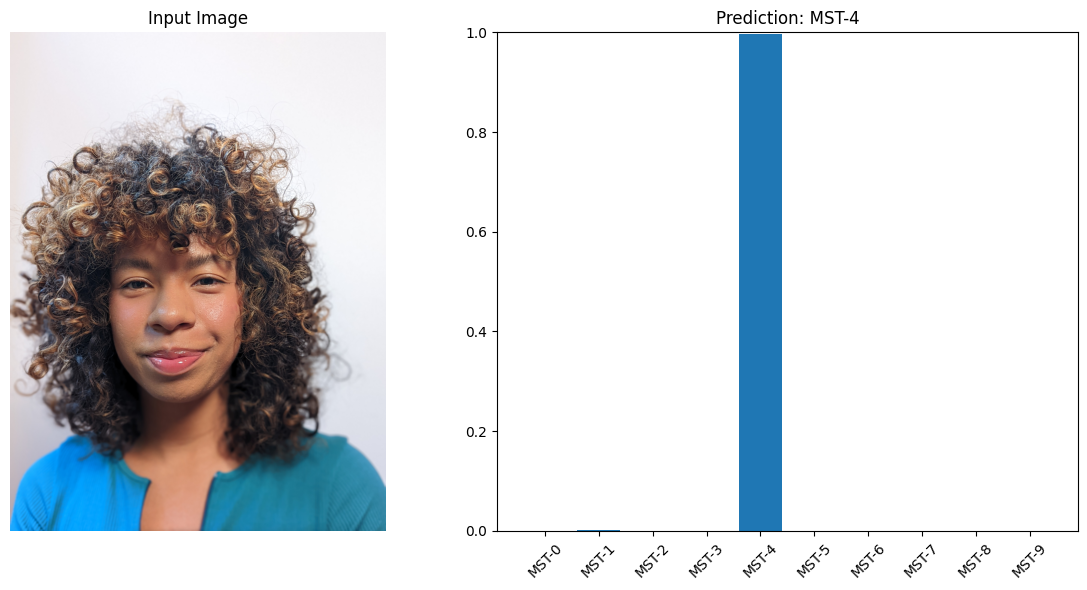


✅ Predicted Skin Tone: MST-4

Class Probabilities:
MST-0: 0.0001
MST-1: 0.0024
MST-2: 0.0000
MST-3: 0.0000
MST-4: 0.9971
MST-5: 0.0003
MST-6: 0.0001
MST-7: 0.0000
MST-8: 0.0000
MST-9: 0.0000


In [19]:
# ---------------------- Imports ----------------------
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ---------------------- Model Definition ----------------------
class LightingAwareAttention(nn.Module):
    def __init__(self, in_channels):
        super(LightingAwareAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=[2, 3], keepdim=True)
        y = self.conv1(avg_pool)
        y = nn.ReLU()(y)
        y = self.conv2(y)
        y = self.sigmoid(y)
        return x * y

class SkinToneModelWithLighting(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(SkinToneModelWithLighting, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.lighting_attention1 = LightingAwareAttention(128)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.lighting_attention2 = LightingAwareAttention(512)

        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.skin_tone_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

        self.lighting_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
        )

        self.classifier = nn.Linear(256 + 128, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.lighting_attention1(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.lighting_attention2(x)
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)

        skin_features = self.skin_tone_branch(x)
        lighting_features = self.lighting_branch(x)
        combined_features = torch.cat((skin_features, lighting_features), dim=1)
        output = self.classifier(combined_features)
        return output

# ---------------------- Prediction Function ----------------------
def predict_single_image(model, image_path, class_names, device):
    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    original = np.array(image)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()

    # Show image + probabilities
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    probs = probabilities.cpu().numpy()
    plt.bar(class_names, probs)
    plt.title(f"Prediction: {class_names[predicted_class]}")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Predicted Skin Tone: {class_names[predicted_class]}")
    print("\nClass Probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probs[i]:.4f}")

# ---------------------- Run Prediction ----------------------
# Parameters
num_classes = 10  # Update to match MST classes
class_names = [f"MST-{i}" for i in range(num_classes)]  # Example: MST-0 to MST-9
model_path = "/kaggle/working/best_skin_tone_model_with_lightingAttention.pth"
image_path = "/kaggle/input/mst-e-data-1/mst-e_data/subject_11/PXL_20220922_194043213.PORTRAIT.jpg"  # Change this to your image path

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkinToneModelWithLighting(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Predict
predict_single_image(model, image_path, class_names, device)
